
# Regression Example
The example below uses a [marketing](https://scikit-learn.org/stable/datasets/toy_dataset.html) dataset,
in order to illustrate a regression activity.

## Workflow
1. Preparation
    1. Load the dataset from a `.csv` file and show a short description
    1. Data preparation, according to background information
    1. Set the __target__ variable, according to background information
    1. Show the two dimensional scatter plots for all the predicting variables with respect to the target
    1. Split the data into *predicting variables* `X` and *target* `y`
        1. here we set the `random_state` variable to make the experiment *repeatable* 
1. First experiment: compute the regression on a single predicting variable
    1. Consider a reduced dataset containing the chosen variable and the target
    1. Fit the `LinearRegression` estimator on the training set
    1. Show the statistical significance of the fitted model
    1. Predict the target for the test set using the *fitted* estimator
    1. Compute the regression coefficients and the quality measures: *Root Mean Squared Error (RMSE)* and *coefficient of determination (r2)*
1. Second experiment: compute the regression considering all the predicting variables
    1. Repeat the steps from 2.2 to 2.5
1. Third experiment: use the `DecisionTreeRegressor` with the entire dataset
    1. Fit the tree using the default hyperparameters, in order to find the 
    maximum depth of the unconstrained tree
    1. Use *cross-validation* to find the optimal *maximum depth* of the tree
    1. Fit the tree with the optmal `max_depth`
    1. Predict and show the *root mean squared error*
1. Fourth experiment: use the `RandomForestRegressor`
    1. Repeat steps from 4.2 to 4.4 (for simplicity, we use the maximum `max_depth` found in 4.1)


In [66]:
# Code source: Claudio Sartori 
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd

random_state = 94922767 # this will be used to guarantee the repeatability of the experiment
ts = 0.3

## Load the dataset from a `.csv` file and show a short description

In [67]:
df = pd.read_csv('./regression_example.csv')
df.head()

,idx,F0,F1,F2,F3,F4,F5,F6,F7,response
0,0,1.509081,-1.049118,1.978885,1.060733,NaN,0.824655,0.819409,-1.157708,214.593802
1,1,0.644764,0.007172,0.004493,4.168748,-0.622817,1.855366,-0.540468,1.141118,151.951717
2,2,0.890241,1.080162,0.168031,0.002733,0.522478,0.407804,1.629592,-1.102599,117.280863
3,3,-0.212410,-1.034267,1.843441,4.486992,-0.610050,0.734101,-0.142660,-0.172119,229.358473
4,4,-0.827402,-2.048496,-0.066242,1.361695,1.268456,-1.084906,1.986556,0.425511,230.153189


## Data Exploration and preparation

##### Show a short description of the columns

In [68]:
df.describe()

,idx,F0,F1,F2,F3,F4,F5,F6,F7,response
count,843.000000,802.000000,807.000000,812.000000,8.020000e+02,805.000000,808.000000,806.000000,812.000000,813.000000
mean,421.000000,-0.037473,0.008466,-0.059965,9.616777e-01,-0.093113,0.034653,-0.019928,-0.034976,3.798356
std,243.497433,1.038115,0.973884,0.991280,1.286476e+00,1.050385,0.957238,0.997345,0.963010,114.189124
min,0.000000,-3.700229,-2.832440,-4.141473,2.007427e-08,-4.072767,-2.968219,-2.850505,-3.948627,-358.659591
25%,210.500000,-0.723630,-0.640017,-0.681924,8.725649e-02,-0.802553,-0.625219,-0.689671,-0.662887,-73.823652
50%,421.000000,-0.032953,0.005693,-0.050789,4.707895e-01,-0.090512,0.051123,-0.014592,-0.049392,-0.159154
75%,631.500000,0.629368,0.681480,0.587393,1.350123e+00,0.611545,0.689203,0.612939,0.614423,75.487094
max,842.000000,3.043062,2.945731,2.925432,9.200073e+00,3.024952,3.210373,2.861549,3.000174,422.794685


##### Show the number of rows with nulls

It is computed subtracting the number of rows in the dataset without nulls from the original number of rows

In [69]:
df.shape[0] - df.dropna().shape[0]

273

#### Drop data that are useless or not usable

In [70]:
df = df.drop('idx', axis=1).dropna().copy()
print(f'Shape of the final dataset: {df.shape[0]} rows and {df.shape[1]} columns')

Shape of the final dataset: 570 rows and 9 columns


In [71]:
df.head()

,F0,F1,F2,F3,F4,F5,F6,F7,response
1,0.644764,0.007172,0.004493,4.168748,-0.622817,1.855366,-0.540468,1.141118,151.951717
2,0.890241,1.080162,0.168031,0.002733,0.522478,0.407804,1.629592,-1.102599,117.280863
3,-0.212410,-1.034267,1.843441,4.486992,-0.610050,0.734101,-0.142660,-0.172119,229.358473
4,-0.827402,-2.048496,-0.066242,1.361695,1.268456,-1.084906,1.986556,0.425511,230.153189
5,-0.635465,-1.112850,-0.330580,6.141348,1.914527,0.408895,-0.364722,-0.731382,-261.116572


## Choose the target and split the data into *predicting variables* `X` and *target* `y`

In [72]:
target_lbl = 'response'
X = df.drop(target_lbl, axis=1)
y = df[target_lbl]

## Show the two dimensional scatter plots for all the predicting variables with respect to the target

In [73]:
n_cols = 3
n_rows = X.shape[1] // n_cols + 1
figwidth = n_cols * 7
figheight = n_rows * 5

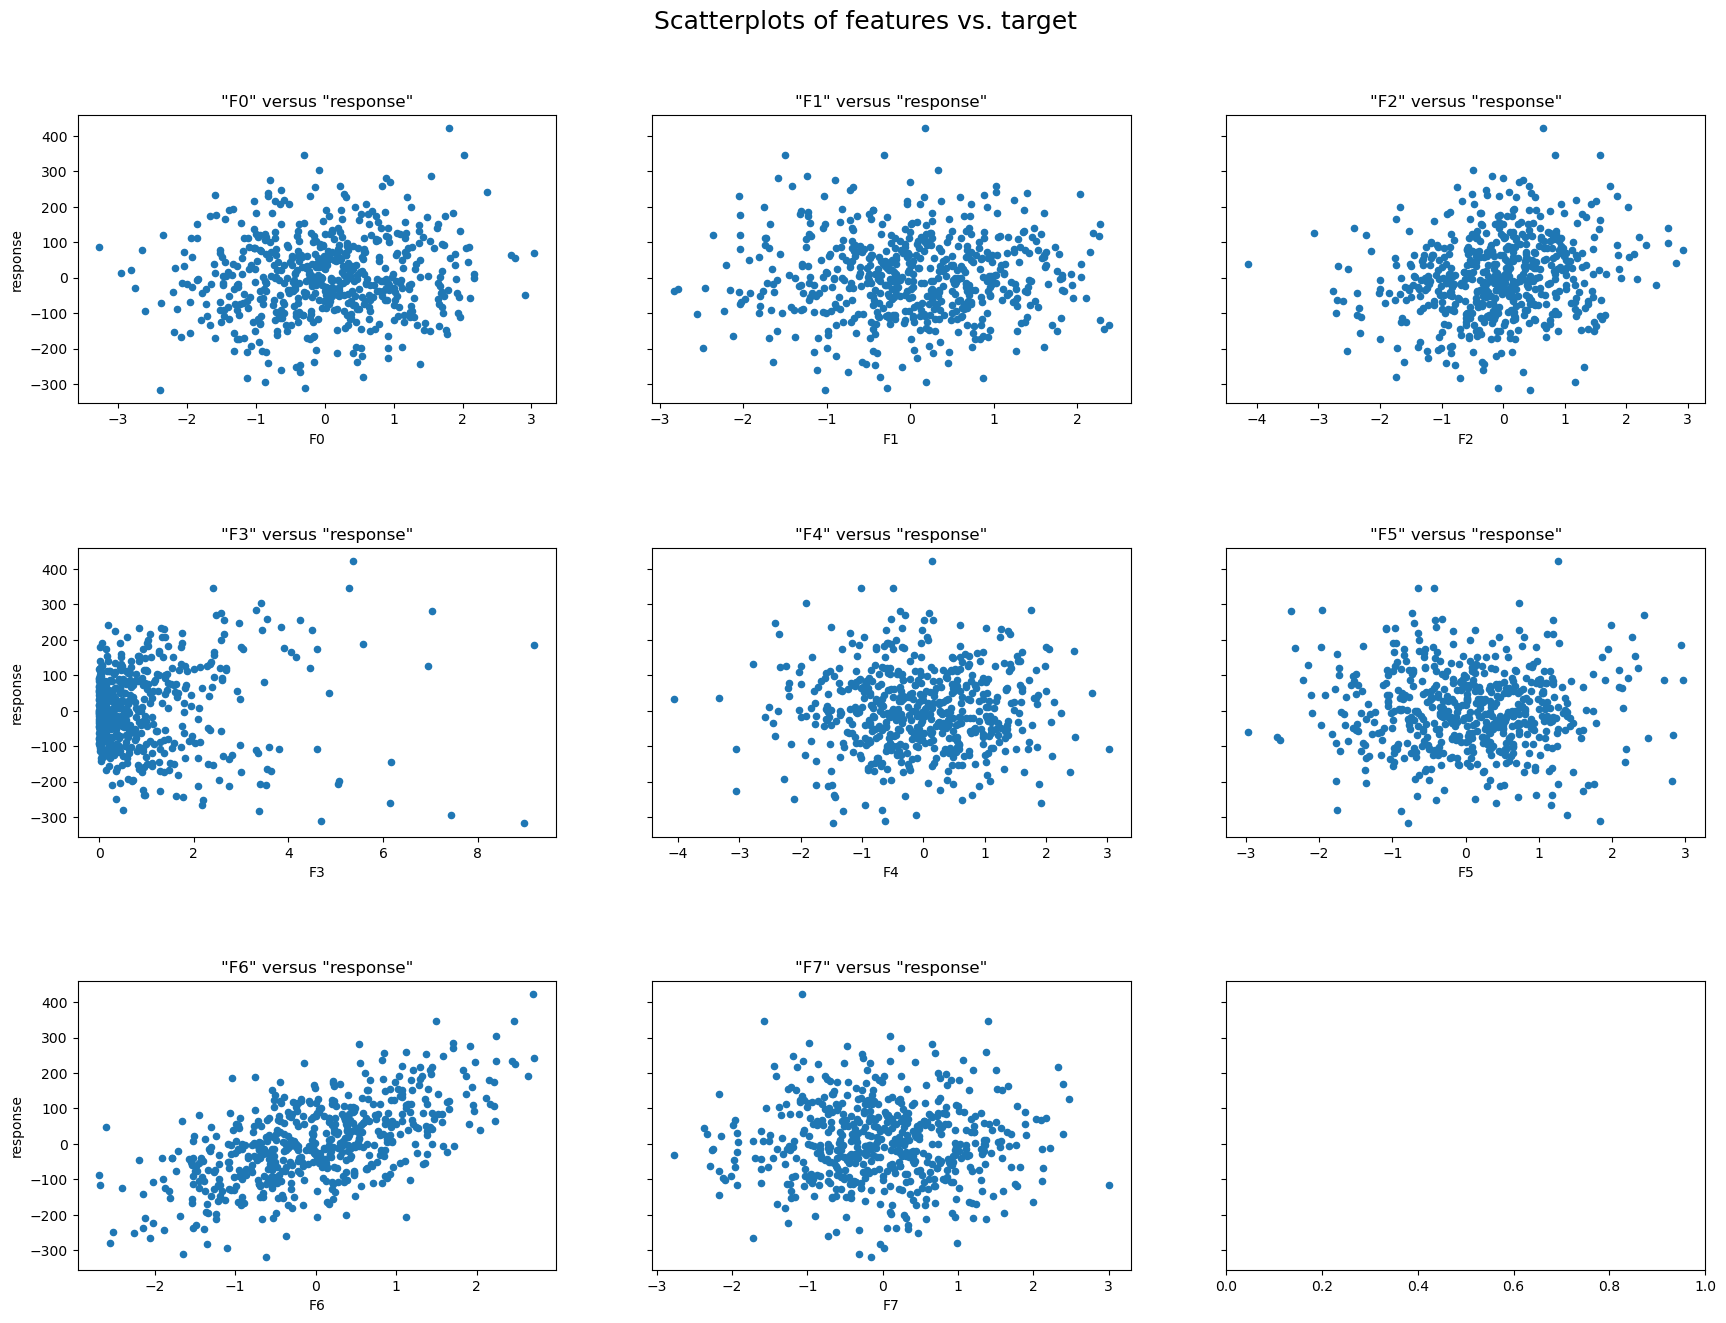

In [74]:
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(figwidth, figheight), sharey=True)
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Scatterplots of features vs. target', fontsize=18, y=0.95)

for col, ax in zip(df.drop(target_lbl, axis=1).columns, axs.ravel()):
    df.plot.scatter(x=col, y=target_lbl, ax=ax, title=f'\"{col}\" versus \"{target_lbl}\"')

<Axes: >

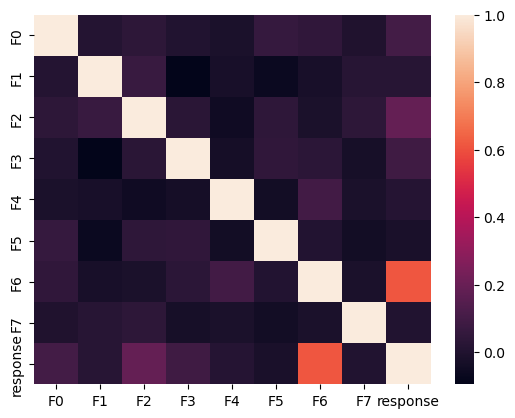

In [75]:
import seaborn as sns
sns.heatmap(df.corr())

## Split the data into *train* and *test* and show the sizes of the two parts
Here we set the `random_state` variable to make the experiment *repeatable*


In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=random_state)

print(f'Training set and test set have {X_train.shape[0]} and {X_test.shape[0]} elements respectively.')

Training set and test set have 399 and 171 elements respectively.


## 2. First experiment - univariate linear regression
We choose the variable exhibiting the highest correlation with respect to the target

Consider a reduced dataset containing the chosen variable and the target

In [77]:
results = pd.DataFrame(columns=['Model', 'RMSE', 'R2'])

In [78]:
pred_var = 'F6'

# create one column arrays
X_train_uni = X_train[pred_var].values.reshape(-1, 1)
X_test_uni = X_test[pred_var].values.reshape(-1, 1)

### Fit the `linear_model` estimator on the training set and predict the target for the test set using the *fitted* estimator

In [79]:
linear_uni = linear_model.LinearRegression()
linear_uni.fit(X_train_uni, y_train)

y_train_pred_uni = linear_uni.predict(X_train_uni)
y_test_pred_uni = linear_uni.predict(X_test_uni)

#### Compute the quality measures

In [80]:
mse_uni = mean_squared_error(y_test, y_test_pred_uni, squared=False)
r2_uni = r2_score(y_test, y_test_pred_uni)

results.loc[len(results)] = [f'Linear univariate on {pred_var}', mse_uni, r2_uni]

## Second experiment: compute the regression considering all the predicting variables

### Now we use the entire data in `X_train` and `X_test` for fitting and predicting

In [81]:
linear_multi = linear_model.LinearRegression()
linear_multi.fit(X_train, y_train)

y_train_pred_multi = linear_multi.predict(X_train)
y_test_pred_multi = linear_multi.predict(X_test)

### Fit, predict and show the results
Now we see the *regression coefficients* resulting from the fitting. 

In particular, *positive coefficients* indicate that the target *increases* with the variable, *negative coefficients* indicate a *decreasing* trend.

The absolute values of the coefficient cannot be considered directly a measure of importance, due to the possibly different orders of magnitude of the data in the different columns (observe above the outputs of `describe`).

In [82]:
pd.DataFrame({
    'Variable': X.columns,
    'Coeffiecient': linear_multi.coef_
})

,Variable,Coeffiecient
0,F0,9.225329
1,F1,2.794846
2,F2,21.766171
3,F3,3.299594
4,F4,-5.532386
5,F5,-6.002884
6,F6,72.949625
7,F7,-2.675824


#### Compute the quality measures

In [83]:
mse_multi = mean_squared_error(y_test, y_test_pred_multi, squared=False)
r2_multi = r2_score(y_test, y_test_pred_multi)

results.loc[len(results)] = [f'Linear multivariate', mse_multi, r2_multi]

## Decision Tree Multivariate Regresson

In [84]:
# Create Decision Tree regression object
from sklearn.tree import DecisionTreeRegressor

#### Fit the tree with default hyperparameters, and find the maximum depth of the unconstrained tree

In [85]:
dt = DecisionTreeRegressor(random_state=random_state)

dt.fit(X_train, y_train)
max_depth = dt.tree_.max_depth
print(f'The maximum depth of the decision tree is {max_depth}.')

The maximum depth of the decision tree is 22.


#### Find the optimal value of the hyperparameter `max_depth` with *cross-validation*
The optimization searches for the *maximum tree depth* guaranteing the smallest mean squared error
At the end, this operation returns also the *fitted best tree* `best_estimator_`

In [86]:
from sklearn.model_selection import GridSearchCV

gs = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=random_state), 
    param_grid={'max_depth': range(1, max_depth)}, 
    scoring='neg_mean_squared_error',)
gs.fit(X_train, y_train)

best_estimator = gs.best_estimator_
best_max_depth = best_estimator.tree_.max_depth

print(f'The best maximum depth is {best_max_depth}.')

The best maximum depth is 2.


In [87]:
y_test_pred_dt = best_estimator.predict(X_test)

rmse = mean_squared_error(y_test, y_test_pred_dt, squared=False)
results.loc[len(results)] = ['Decision tree', rmse, np.nan]

print(f'Decision Tree Regression - RMSE = {rmse:.2f}')

Decision Tree Regression - RMSE = 89.83


#### Show the tree

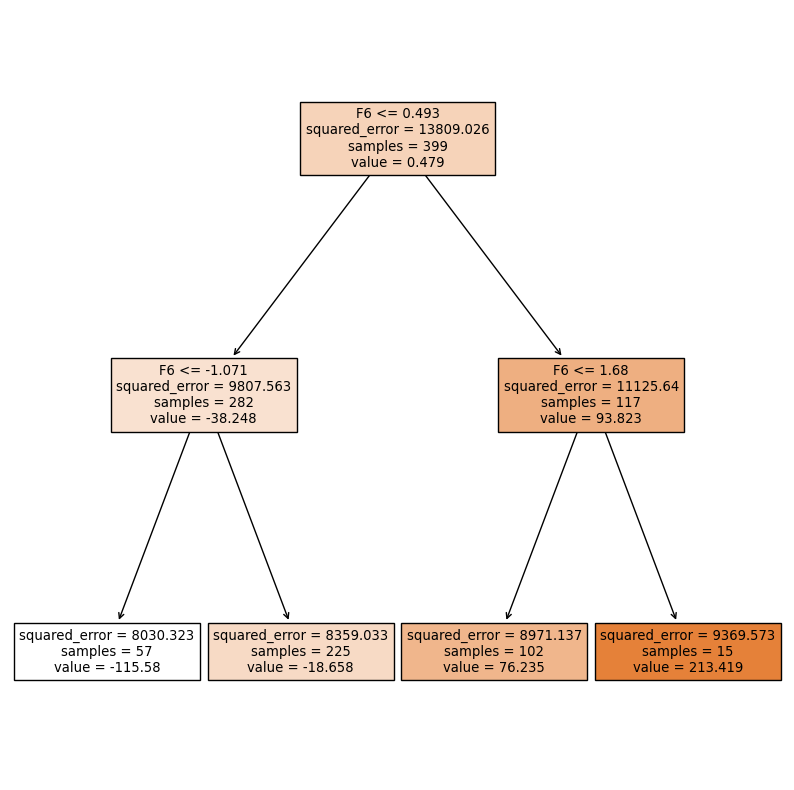

In [88]:
from sklearn.tree import plot_tree
from matplotlib.pyplot import figure

fig = figure(figsize=(10, 10))
plot_tree(best_estimator, filled=True, feature_names=list(X.columns))
plt.show()

## Random Forest Multivariate Regresson

In [89]:
# Create Random Forest regression object
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=random_state)
params_grid = {
    'max_depth': range(1, max_depth)
}

# search for the best configuration of the parameters in params_grid
gs = GridSearchCV(estimator=rf, param_grid=params_grid, scoring='neg_mean_squared_error')

gs.fit(X_train, y_train)

rf_best = gs.best_estimator_

In [90]:
print(f'The optimal maximum depth for the trees in the random forest is {rf_best.max_depth}')

The optimal maximum depth for the trees in the random forest is 3


In [91]:
y_test_pred_rf = rf_best.predict(X_test)

rmse = mean_squared_error(y_test, y_test_pred_rf, squared=False)
results.loc[len(results)] = ['Random Forest', rmse, np.nan]

print(f'Random Forest Regression - RMSE = {rmse:.2f}')

Random Forest Regression - RMSE = 84.70


### Plot the prediction of every model, compare it with the real test set, and print the metrics $R^2$ and RMSE 

In [92]:
df_test_sorted=X_test
df_test_sorted['y_pred_dt']=y_test_pred_dt
df_test_sorted['y_pred_multi']=y_test_pred_multi
df_test_sorted['y_pred_uni']=y_test_pred_uni
df_test_sorted['y_pred_rf']=y_test_pred_rf
df_test_sorted[target_lbl]=y_test
df_test_sorted = df_test_sorted.sort_values(by=pred_var)

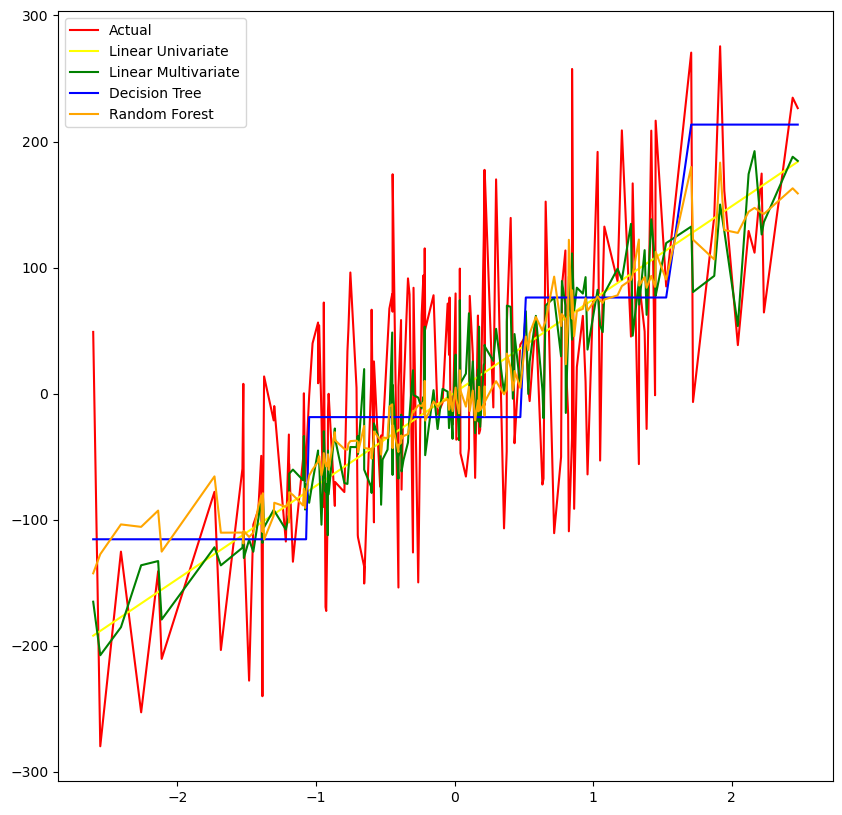

In [93]:
plt.figure(figsize=(10, 10))
plt.plot(df_test_sorted[pred_var], df_test_sorted[target_lbl], label='Actual', color='red')
plt.plot(df_test_sorted[pred_var], df_test_sorted['y_pred_uni'], label='Linear Univariate', color='yellow')
plt.plot(df_test_sorted[pred_var], df_test_sorted['y_pred_multi'], label='Linear Multivariate', color='green')
plt.plot(df_test_sorted[pred_var], df_test_sorted['y_pred_dt'], label='Decision Tree', color='blue')
plt.plot(df_test_sorted[pred_var], df_test_sorted['y_pred_rf'], label='Random Forest', color='orange')
plt.legend()
plt.show()

In [94]:
results

,Model,RMSE,R2
0,Linear univariate on F6,85.121744,0.338477
1,Linear multivariate,81.104168,0.399448
2,Decision tree,89.827208,NaN
3,Random Forest,84.703295,NaN


## Final observations
### Linear regression
The multivariate regression with all the predicting variables available with respect to the univariate regression has 
- lower RMSE 
- higher coefficient of determination 

### Decision Tree and Random Forest regression
- Decision Tree and Random Forest have an RMSE slightly higher than multivariate linear regression



## Control questions
1. observing the multi-variate experiment, what variable has the higher effect on the target?
1. is there a variable having an almost negligible effect on the target?
1. try to repeat the univariate experiment with other columns and comment the results